# Analyse IMGEP Evaluation

In [1]:
from autodiscjax import DictTree
import experiment_config
import evaluation_config
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex = True)
from matplotlib.colors import hsv_to_rgb
from sklearn.cluster import MeanShift, estimate_bandwidth

## Load experiment+evaluation history

In [2]:
experiment_history_filepath = "experiment_data/experiment_history.pickle"
experiment_history = DictTree.load(experiment_history_filepath)

evaluation_history_filepath = "evaluation_data/evaluation_history.pickle"
evaluation_history = DictTree.load(evaluation_history_filepath)

In [3]:
config = experiment_config.ExperimentConfig()
observed_node_ids = config.observed_node_ids
eval_config = evaluation_config.EvaluationConfig()
pipeline_config = eval_config.get_pipeline_config()
perturbation_config = eval_config.get_perturbation_config()

## Goals of the system

### Filter out non-convergent trajectories

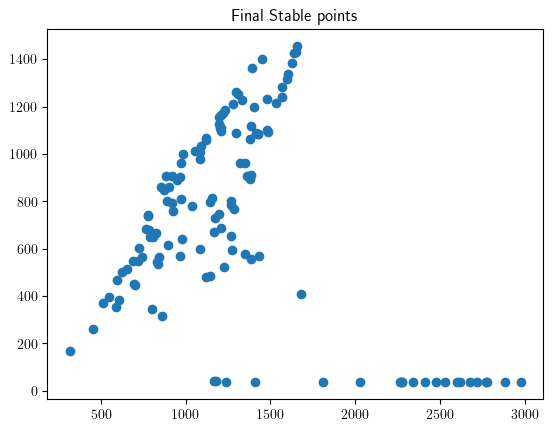

In [4]:
has_converged_ids = jnp.where(experiment_history.system_rollout_statistics_library.is_stable[:, observed_node_ids].all(-1))[0]

# goals = bins where they are final (stable) points
plt.figure()
plt.scatter(
    experiment_history.reached_goal_embedding_library[has_converged_ids, 0], 
    experiment_history.reached_goal_embedding_library[has_converged_ids, 1]
)
plt.title("Final Stable points")
plt.show()

### Bin-based definition

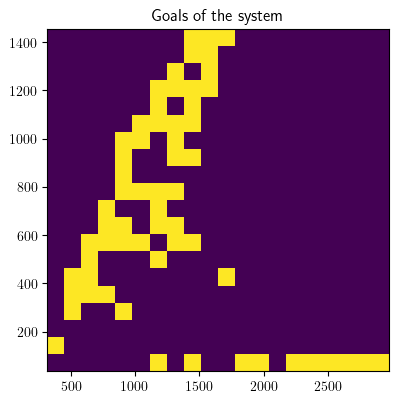

In [5]:
y1 = experiment_history.reached_goal_embedding_library[has_converged_ids, 0]
y2 = experiment_history.reached_goal_embedding_library[has_converged_ids, 1]
Hf, xedges, yedges = jnp.histogram2d(x=y1, y=y2, bins=20, range=[[y1.min(), y1.max()], [y2.min(), y2.max()]])

Hf = Hf.transpose() > 0
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(131, title="Goals of the system")
plt.imshow(
    Hf,
    interpolation="nearest",
    origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect=(y1.max() - y1.min()) / (y2.max() - y2.min()),
)
# plt.colorbar()
plt.show()

In [6]:
print(Hf.sum())

61


### Clustering-based definition

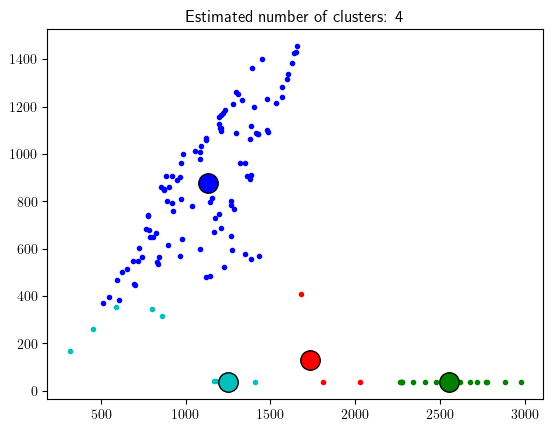

In [7]:
X = experiment_history.reached_goal_embedding_library[has_converged_ids, :]

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = jnp.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1)
plt.clf()

colors = "bgrcmyk"
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

## Robustness of the system

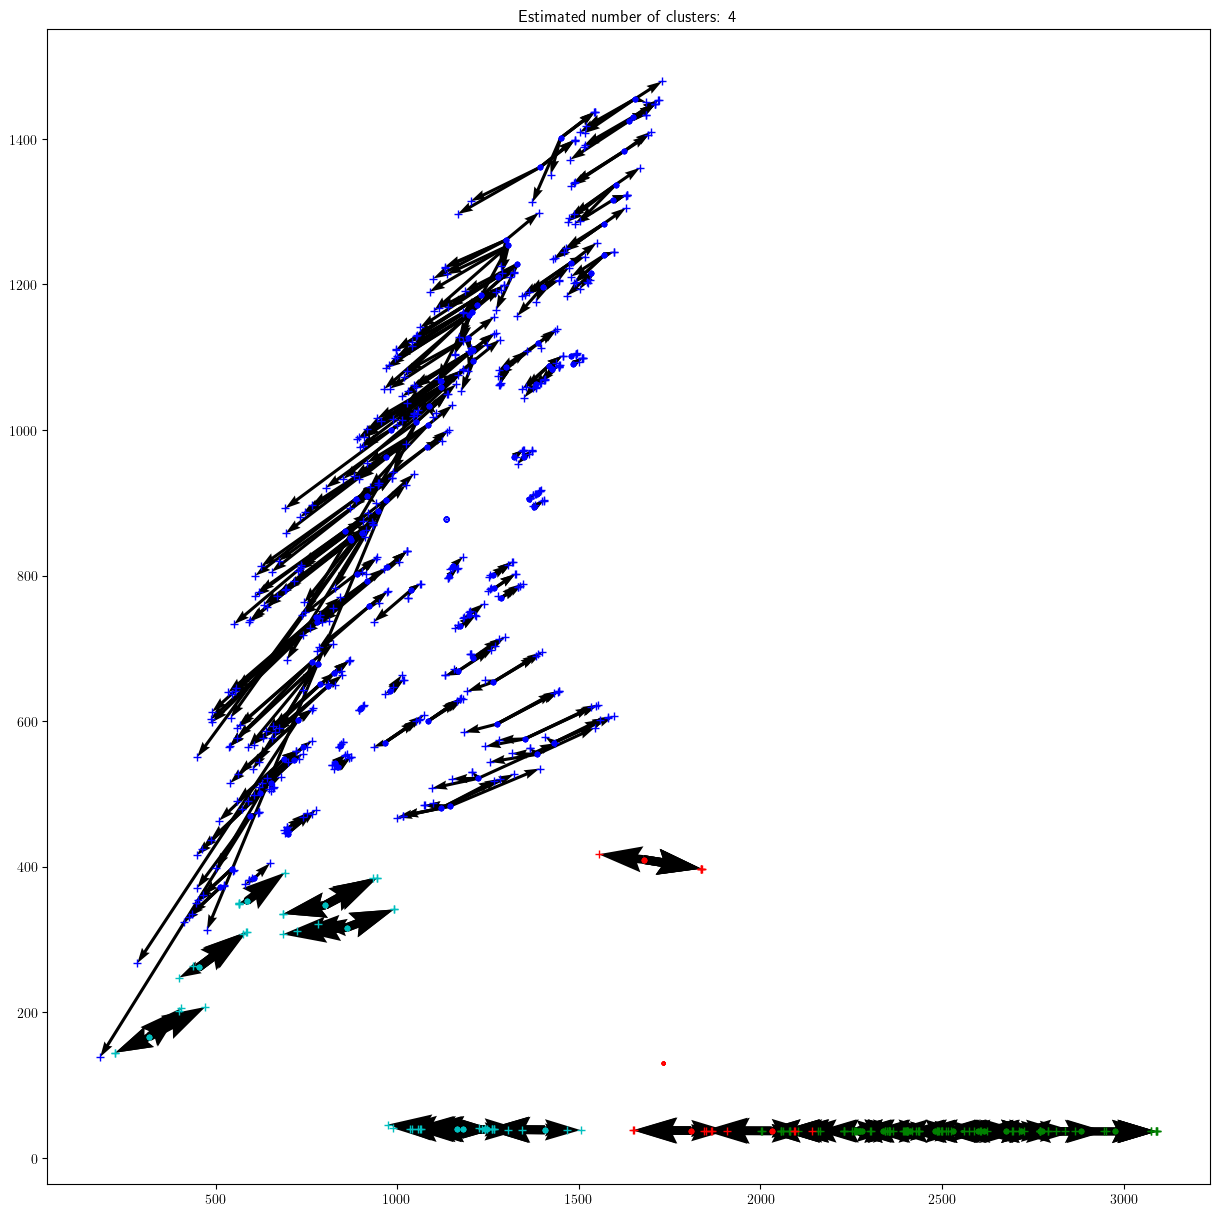

In [8]:
plt.figure(figsize=(15,15))
plt.clf()

#TODO: normalize distance

colors = "bgrcmyk"

for cluster_idx, col in zip(range(n_clusters_), colors):
    
    cluster_members = labels == cluster_idx
    cluster_center = cluster_centers[cluster_idx]
    cluster_X = jnp.repeat(X[cluster_members][:, jnp.newaxis, :], pipeline_config.n_perturbations, -2).reshape(-1, len(observed_node_ids))
    cluster_perturbed_X = evaluation_history.system_output_library.ys[has_converged_ids, :, :, -1][cluster_members][...,observed_node_ids].reshape(-1, len(observed_node_ids))
    
    #cluster_sensitivity = jnp.sqrt(((cluster_center[jnp.newaxis] - cluster_X)** 2).sum(-1))
    cluster_sensitivity = jnp.sqrt(((cluster_X - cluster_perturbed_X)** 2).sum(-1))
    cluster_robustness = 10*jnp.reciprocal(cluster_sensitivity.mean()).item()

    plt.plot(cluster_X[:, 0], cluster_X[:, 1], col + ".")
    plt.plot(cluster_perturbed_X[:, 0], cluster_perturbed_X[:, 1], col + "+")
    plt.quiver(cluster_X[:, 0], cluster_X[:, 1], cluster_perturbed_X[:, 0]-cluster_X[:, 0], cluster_perturbed_X[:, 1]-cluster_X[:, 1], angles='xy', scale_units='xy', scale=1)
    plt.scatter(
        [cluster_center[0]],
        [cluster_center[1]],
        marker=r'$\odot$',
        color=col,
        s=(20*cluster_robustness)**4,
    )

#plt.colorbar()
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

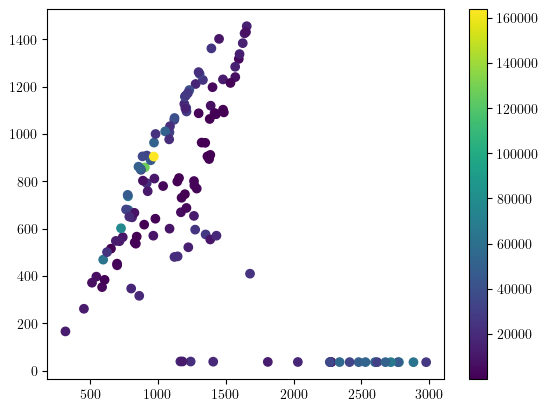

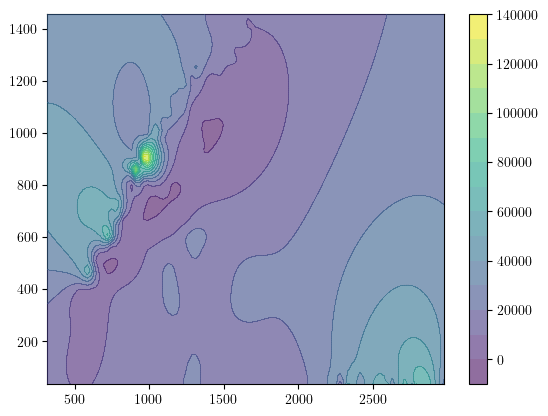

In [9]:
perturbed_X = evaluation_history.system_output_library.ys[has_converged_ids, :, :, -1][..., observed_node_ids]
sensitivity=((X[:, jnp.newaxis, :]-perturbed_X)**2).sum(-1).mean(-1)
plt.scatter(X[:, 0], X[:, 1], c=sensitivity)
plt.colorbar()
plt.show()

plt.figure()
from scipy.interpolate import RBFInterpolator, griddata
extrapolate = True
method = "linear"
x, y = jnp.meshgrid(jnp.linspace(X.min(0)[0], X.max(0)[0], 100),
                   jnp.linspace(X.min(0)[1], X.max(0)[1], 100))
x_dense = jnp.stack([x.flatten(), y.flatten()], axis=-1)
if extrapolate:
    IM_fun = RBFInterpolator(X, sensitivity, smoothing=0.01, kernel=method)
    IM_grid = IM_fun(x_dense).reshape(100,100)

else:
    IM_grid = griddata(X, sensitivity, x_dense, method=method).reshape(100,100)

plt.contour(x, y, IM_grid, 15, zorder=4, linewidths=.25, linestyles='dashed', colors='k', alpha=0.6)
plt.contourf(x, y, IM_grid, 15, zorder=4, alpha=0.6)
plt.colorbar()
plt.show()

(10, 10)


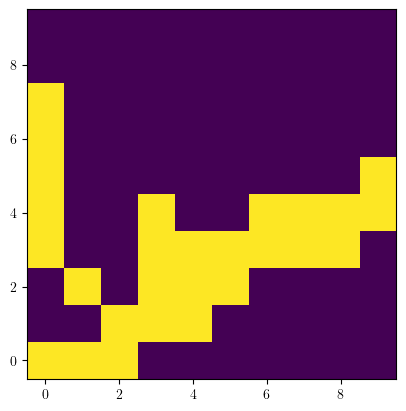

In [10]:
import jax.numpy as jnp
robX = X[jnp.where(sensitivity<20000)[0]]
H, xedges, yedges = jnp.histogram2d(
    x=robX[:, 0],
    y=robX[:, 1],
    bins=10,
    range=jnp.stack(
        [jnp.nanmin(X, 0), 
         jnp.nanmax(X, 0)] 
    ).transpose(),
)
H = (H > 0)
print(H.shape)
plt.imshow(H, origin="lower")
plt.show()

### Example trajectories

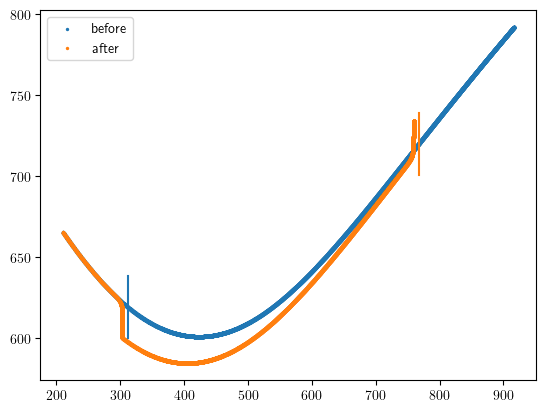

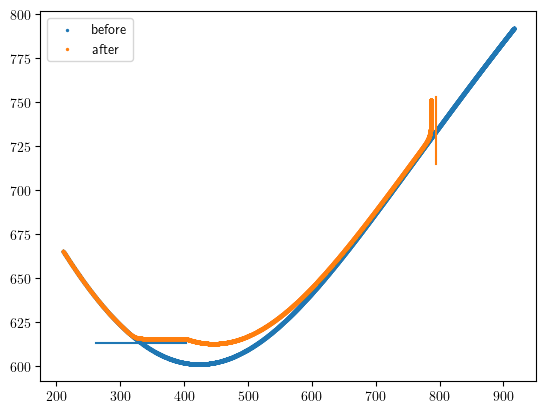

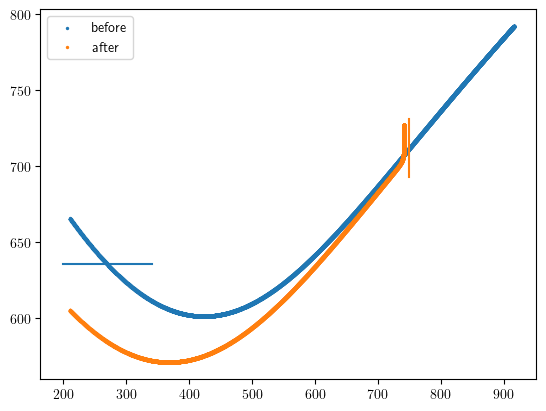

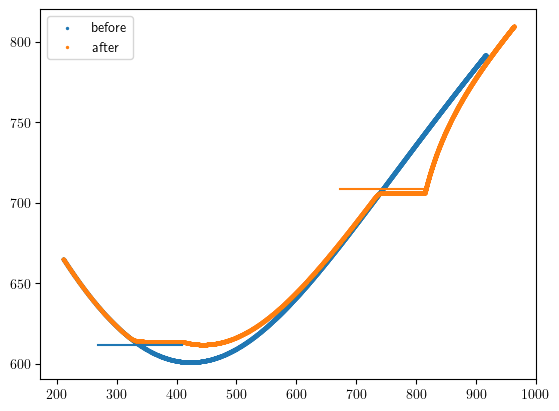

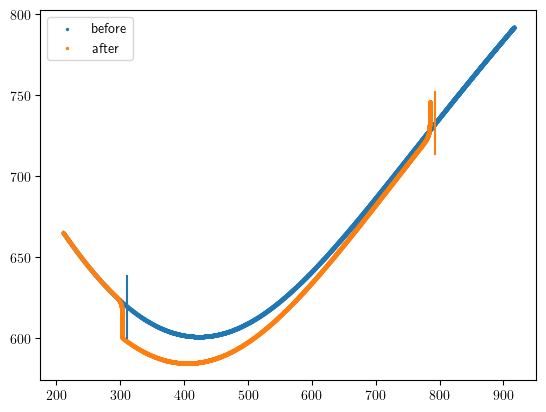

In [11]:
# Show results
sample_idx = 3
perturbed_node_ids = perturbation_config.perturbed_node_ids
for perturbation_idx in range(pipeline_config.n_perturbations):
    plt.figure()
    plt.scatter(experiment_history.system_output_library.ys[sample_idx, perturbed_node_ids[0]], experiment_history.system_output_library.ys[sample_idx, perturbed_node_ids[1]], s=2, label="before")
    plt.scatter(evaluation_history.system_output_library.ys[sample_idx, perturbation_idx, perturbed_node_ids[0]], evaluation_history.system_output_library.ys[sample_idx, perturbation_idx, perturbed_node_ids[1]], s=2, label="after")
    for wall_idx in range(perturbation_config.n_walls):
        plt.plot(evaluation_history.perturbation_params_library.y[perturbed_node_ids[0]][sample_idx, perturbation_idx, wall_idx].squeeze(),
                 evaluation_history.perturbation_params_library.y[perturbed_node_ids[1]][sample_idx, perturbation_idx, wall_idx].squeeze())
    plt.legend()
    plt.show()